In [1]:
import sys
import os
sys.path.insert(0,'/home/prashant/unilm/layoutlmv3/examples/')
from gat_utils import *
# from ..examples.gat_utils import *

from PIL import Image, ImageDraw, ImageFont
import pickle
import numpy as np
import pandas as pd
import json
from collections import defaultdict
from datasets import load_metric 
metric = load_metric("seqeval")

/home/prashant/anaconda3/envs/layoutlmv3/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_dataset = pickle.load(open('/home/prashant/unilm/layoutlmv3/debug/cord_train_processed_dataset.pkl','rb'))
test_dataset = pickle.load(open('/home/prashant/unilm/layoutlmv3/debug/cord_test_processed_dataset.pkl','rb'))
# test_dataset_pre = pickle.load(open('/data1/prashant/DocIE/debug_v2/test_dataset_pre.pkl','rb'))

id_to_image_test_json_ = json.load(open('/home/prashant/unilm/layoutlmv3/data/id_to_image_test_cord.json'))
id_to_image_test_json = {int(k):v for k,v in id_to_image_test_json_.items()}
# image_to_id_test_json = json.load(open('/data1/prashant/DocIE/data/image_to_id_test.json'))
image_to_id_test_json = {j:i for i, j in id_to_image_test_json.items()}

id_to_image_eval_json_ = json.load(open('/home/prashant/unilm/layoutlmv3/data/id_to_image_eval_cord.json'))
id_to_image_eval_json = {int(k):v for k,v in id_to_image_eval_json_.items()}
image_to_id_eval_json = {j:i for i, j in id_to_image_eval_json.items()}

image_to_id_train_json = json.load(open('/home/prashant/unilm/layoutlmv3/data/image_to_id_train_cord.json'))
# image_to_id_train_json = {int(k):v for k,v in id_to_image_train_json_.items()}
id_to_image_train_json = {int(j):i for i, j in image_to_id_train_json.items()}

few_shot_info = json.loads(open('/home/prashant/unilm/layoutlmv3/data/cord_few_shot_info.json','r').read())
# image_to_id_dict = json.loads(open('/data1/prashant/DocIE/data/image_to_id.json','r').read())

# datasets = pickle.load(open('/data1/prashant/DocIE/data/datasets.pkl', 'rb'))

In [3]:
width_height_train, width_height_eval, width_height_test = get_widths_heights_cord(id_to_image_train_json, id_to_image_eval_json, id_to_image_test_json)

In [4]:
# label_list = ["O","B-MENU.NM","B-MENU.NUM","B-MENU.UNITPRICE","B-MENU.CNT","B-MENU.DISCOUNTPRICE","B-MENU.PRICE","B-MENU.ITEMSUBTOTAL","B-MENU.VATYN","B-MENU.ETC","B-MENU.SUB_NM","B-MENU.SUB_UNITPRICE","B-MENU.SUB_CNT","B-MENU.SUB_PRICE","B-MENU.SUB_ETC","B-VOID_MENU.NM","B-VOID_MENU.PRICE","B-SUB_TOTAL.SUBTOTAL_PRICE","B-SUB_TOTAL.DISCOUNT_PRICE","B-SUB_TOTAL.SERVICE_PRICE","B-SUB_TOTAL.OTHERSVC_PRICE","B-SUB_TOTAL.TAX_PRICE","B-SUB_TOTAL.ETC","B-TOTAL.TOTAL_PRICE","B-TOTAL.TOTAL_ETC","B-TOTAL.CASHPRICE","B-TOTAL.CHANGEPRICE","B-TOTAL.CREDITCARDPRICE","B-TOTAL.EMONEYPRICE","B-TOTAL.MENUTYPE_CNT","B-TOTAL.MENUQTY_CNT","I-MENU.NM","I-MENU.NUM","I-MENU.UNITPRICE","I-MENU.CNT","I-MENU.DISCOUNTPRICE","I-MENU.PRICE","I-MENU.ITEMSUBTOTAL","I-MENU.VATYN","I-MENU.ETC","I-MENU.SUB_NM","I-MENU.SUB_UNITPRICE","I-MENU.SUB_CNT","I-MENU.SUB_PRICE","I-MENU.SUB_ETC","I-VOID_MENU.NM","I-VOID_MENU.PRICE","I-SUB_TOTAL.SUBTOTAL_PRICE","I-SUB_TOTAL.DISCOUNT_PRICE","I-SUB_TOTAL.SERVICE_PRICE","I-SUB_TOTAL.OTHERSVC_PRICE","I-SUB_TOTAL.TAX_PRICE","I-SUB_TOTAL.ETC","I-TOTAL.TOTAL_PRICE","I-TOTAL.TOTAL_ETC","I-TOTAL.CASHPRICE","I-TOTAL.CHANGEPRICE","I-TOTAL.CREDITCARDPRICE","I-TOTAL.EMONEYPRICE","I-TOTAL.MENUTYPE_CNT","I-TOTAL.MENUQTY_CNT"]
label_list = ['O', 'B-MENU.NM', 'B-MENU.NUM', 'B-MENU.UNITPRICE', 'B-MENU.CNT', 'B-MENU.DISCOUNTPRICE', 'B-MENU.PRICE', 'B-MENU.ITEMSUBTOTAL', 'B-MENU.VATYN', 'B-MENU.ETC', 'B-MENU.SUB_NM', 'B-MENU.SUB_UNITPRICE', 'B-MENU.SUB_CNT', 'B-MENU.SUB_PRICE', 'B-MENU.SUB_ETC', 'B-VOID_MENU.NM', 'B-VOID_MENU.PRICE', 'B-SUB_TOTAL.SUBTOTAL_PRICE', 'B-SUB_TOTAL.DISCOUNT_PRICE', 'B-SUB_TOTAL.SERVICE_PRICE', 'B-SUB_TOTAL.OTHERSVC_PRICE', 'B-SUB_TOTAL.TAX_PRICE', 'B-SUB_TOTAL.ETC', 'B-TOTAL.TOTAL_PRICE', 'B-TOTAL.TOTAL_ETC', 'B-TOTAL.CASHPRICE', 'B-TOTAL.CHANGEPRICE', 'B-TOTAL.CREDITCARDPRICE', 'B-TOTAL.EMONEYPRICE', 'B-TOTAL.MENUTYPE_CNT', 'B-TOTAL.MENUQTY_CNT', 'I-MENU.NM', 'I-MENU.NUM', 'I-MENU.UNITPRICE', 'I-MENU.CNT', 'I-MENU.DISCOUNTPRICE', 'I-MENU.PRICE', 'I-MENU.ITEMSUBTOTAL', 'I-MENU.VATYN', 'I-MENU.ETC', 'I-MENU.SUB_NM', 'I-MENU.SUB_UNITPRICE', 'I-MENU.SUB_CNT', 'I-MENU.SUB_PRICE', 'I-MENU.SUB_ETC', 'I-VOID_MENU.NM', 'I-VOID_MENU.PRICE', 'I-SUB_TOTAL.SUBTOTAL_PRICE', 'I-SUB_TOTAL.DISCOUNT_PRICE', 'I-SUB_TOTAL.SERVICE_PRICE', 'I-SUB_TOTAL.OTHERSVC_PRICE', 'I-SUB_TOTAL.TAX_PRICE', 'I-SUB_TOTAL.ETC', 'I-TOTAL.TOTAL_PRICE', 'I-TOTAL.TOTAL_ETC', 'I-TOTAL.CASHPRICE', 'I-TOTAL.CHANGEPRICE', 'I-TOTAL.CREDITCARDPRICE', 'I-TOTAL.EMONEYPRICE', 'I-TOTAL.MENUTYPE_CNT', 'I-TOTAL.MENUQTY_CNT']
# color_list = ['red','blue','green','brown','violet','orange','aqua']
label_to_color = {}
for lab in label_list:
    if lab == "O":
        label_to_color[lab] = 'red'
    elif "B-MENU" in lab:
        label_to_color[lab] = 'purple'
    elif "I-MENU" in lab:
        label_to_color[lab] = 'violet'
    elif "B-SUB_TOTAL" in lab:
        label_to_color[lab] =  'blue'
    elif "I-SUB_TOTAL" in lab:
        label_to_color[lab] = 'green'
    elif "B-TOTAL" in lab:
        label_to_color[lab] = 'orange'
    elif "I-TOTAL" in lab:
        label_to_color[lab] = 'aqua'
    else:
        label_to_color[lab] = 'silver'

In [5]:
# #annotations
# with open(f'/data1/prashant/DocDatasets/FUNSD/raw/testing_data/annotations/{id_to_image_json[10]}.json') as f:
#   data = json.load(f)

# FS-baseline-preds 
with open('/data/prashant/unilm/layoutlmv3/results/test-layoutlmv3-cord-fs-4-0/test_predictions.txt','r') as f:
  test_fs_preds = [line.strip().split() for line in f.readlines()]
  
# GAT-closest-preds
with open('/data/prashant/unilm/layoutlmv3/results/test-layoutlmv3-cord-gat-closest-4-0-h4-d4/test_predictions.txt','r') as f:
  test_gat_closest_preds = [line.strip().split() for line in f.readlines()]

# GAT-60-angles-preds
with open('/data/prashant/unilm/layoutlmv3/results/test-layoutlmv3-cord-gat-60-angles-v2-4-0-h4-d4/test_predictions.txt','r') as f:
  test_gat_angles_preds = [line.strip().split() for line in f.readlines()]
  
image_id = 45
ground_truth = [label_list[l] for l in test_dataset['labels'][0] if l!=-100]

In [21]:
ground_truth = [label_list[l] for l in test_dataset['labels'][image_id] if l!=-100]
ground_truth
for lab in label_list:
    if lab == "O":
        label_to_color[lab] = 'red'
    elif "B-MENU" in lab:
        label_to_color[lab] = 'purple'
    elif "I-MENU" in lab:
        label_to_color[lab] = 'violet'
    elif "I-SUB_TOTAL" in lab:
        label_to_color[lab] = 'green'
    elif "TOTAL.TOTAL_PRICE" in lab:
        label_to_color[lab] = 'blue'
    elif "TOTAL.CASHPRICE" in lab:
        label_to_color[lab] =  'orange'
    elif "B-TOTAL.CHANGEPRICE" in lab:
        label_to_color[lab] =  'orange'
    elif "I-TOTAL.CHANGEPRICE" in lab:
        label_to_color[lab] = 'aqua'
    else:
        label_to_color[lab] = 'silver'

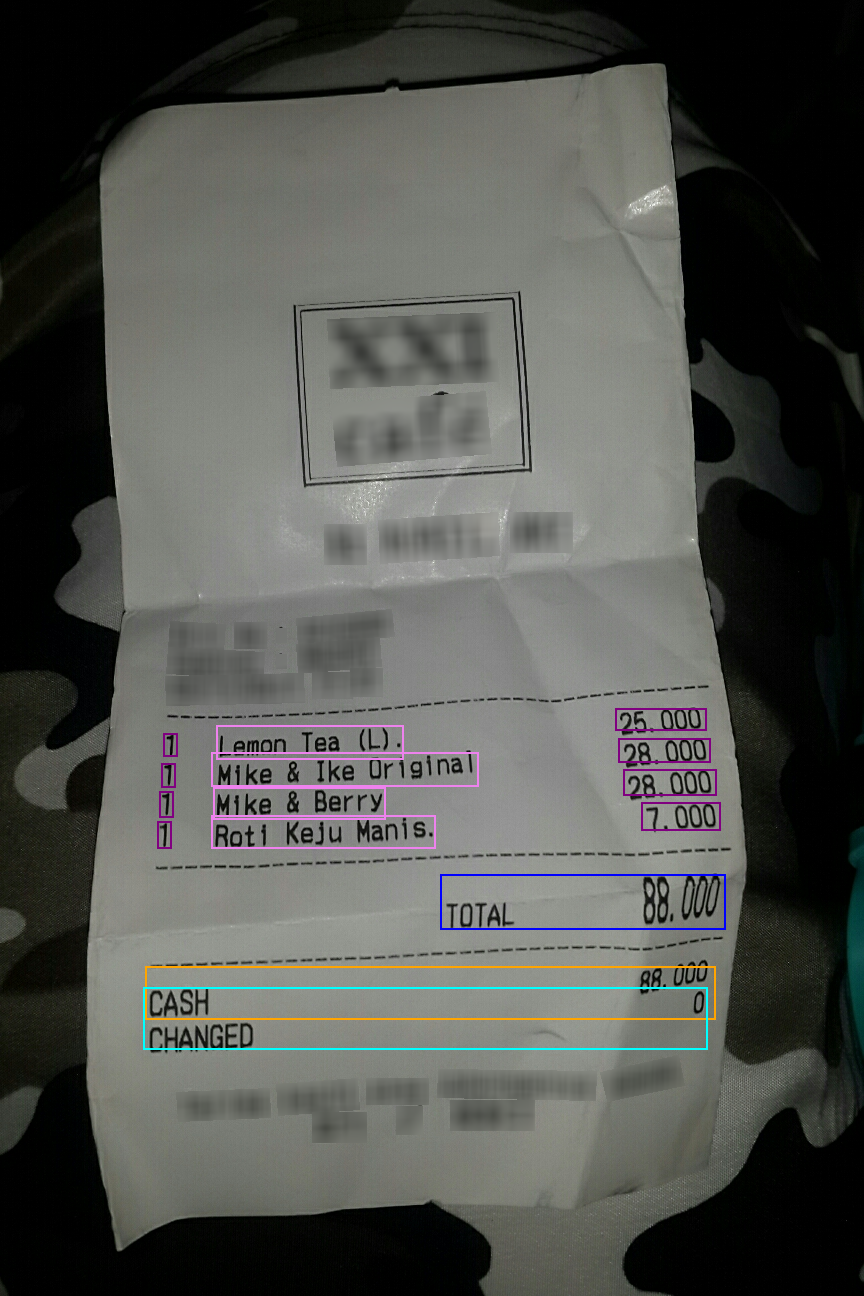

In [22]:
#Ground truth
# j = 10
image = Image.open(f"/home/prashant/DocDatasets/CORD/raw/test/image/{id_to_image_test_json[image_id]}.png")
image = image.convert("RGB")
draw = ImageDraw.Draw(image, "RGBA")
font = ImageFont.load_default()
width, height = image.size
# for z, lab in enumerate(label_to_color):
#     draw.text((10,z*10), text=f'{lab}:{label_to_color[lab]}', fill=label_to_color[lab], font=font)

for bbox, label in zip(test_dataset['bbox'][image_id], test_dataset['labels'][image_id]):
    if label!=-100:
        un_bb = unnormalize_box(bbox, width, height)
        draw.rectangle(un_bb, outline=label_to_color[label_list[label]], width=2)
        # draw.text((un_bb[0]+5, un_bb[1]), text=label_list[label], fill=label_to_color[label_list[label]], font=font)
        
image

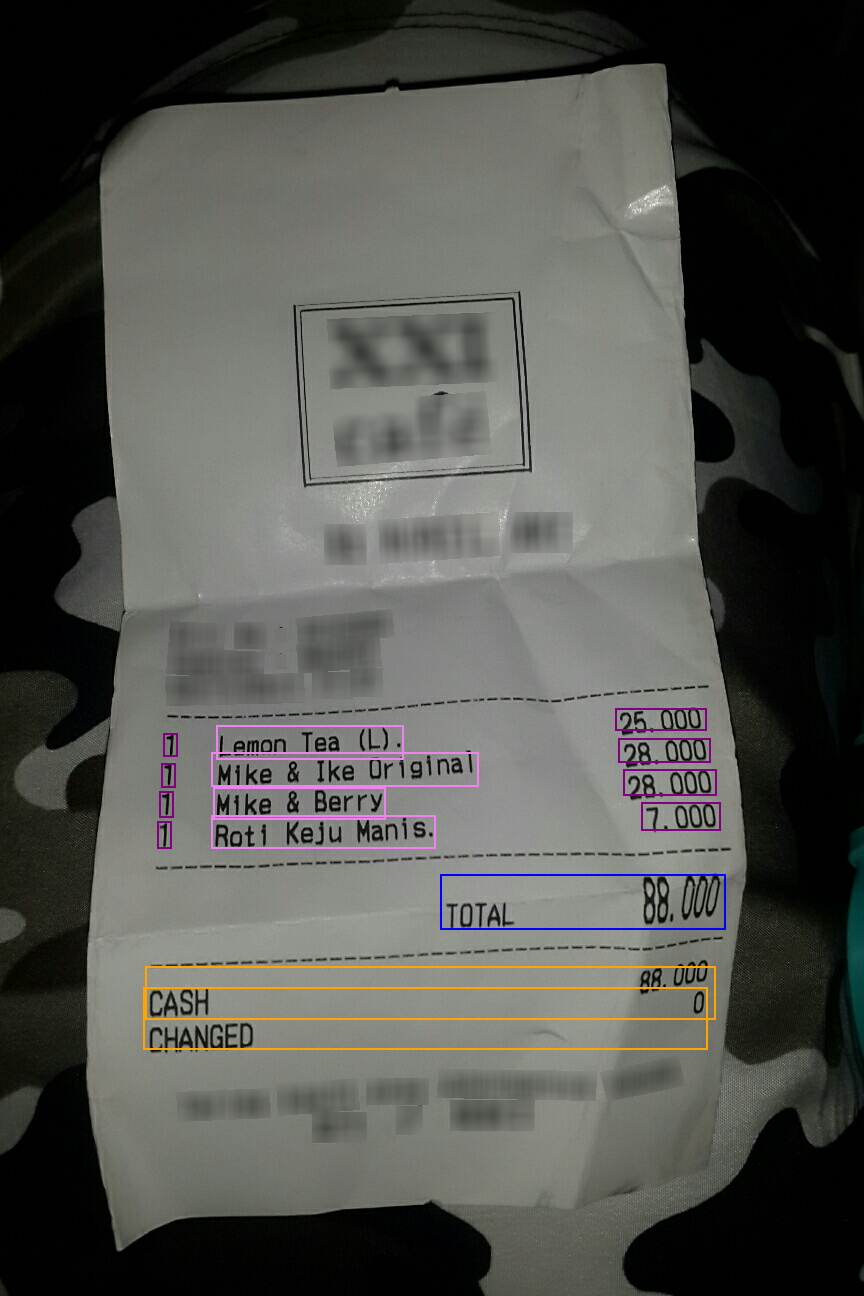

In [23]:
#FS-Baseline
k = 0
image = Image.open(f"/home/prashant/DocDatasets/CORD/raw/test/image/{id_to_image_test_json[image_id]}.png")
image = image.convert("RGB")
draw = ImageDraw.Draw(image, "RGBA")
width, height = image.size
# for z, lab in enumerate(label_to_color):
#     draw.text((10,z*10), text=f'{lab}:{label_to_color[lab]}', fill=label_to_color[lab], font=font)

for bbox, label in zip(test_dataset['bbox'][image_id], test_dataset['labels'][image_id]):
    if label!=-100:
        un_bb = unnormalize_box(bbox, width, height)
        draw.rectangle(un_bb, outline=label_to_color[test_fs_preds[image_id][k]], width=2)
        # print(label)
        # draw.text((10,10))
        # draw.text((un_bb[0]+5, un_bb[1]), text=label_list[label], fill=label_to_color[test_fs_preds[image_id][k]], font=font)
        k+=1
image

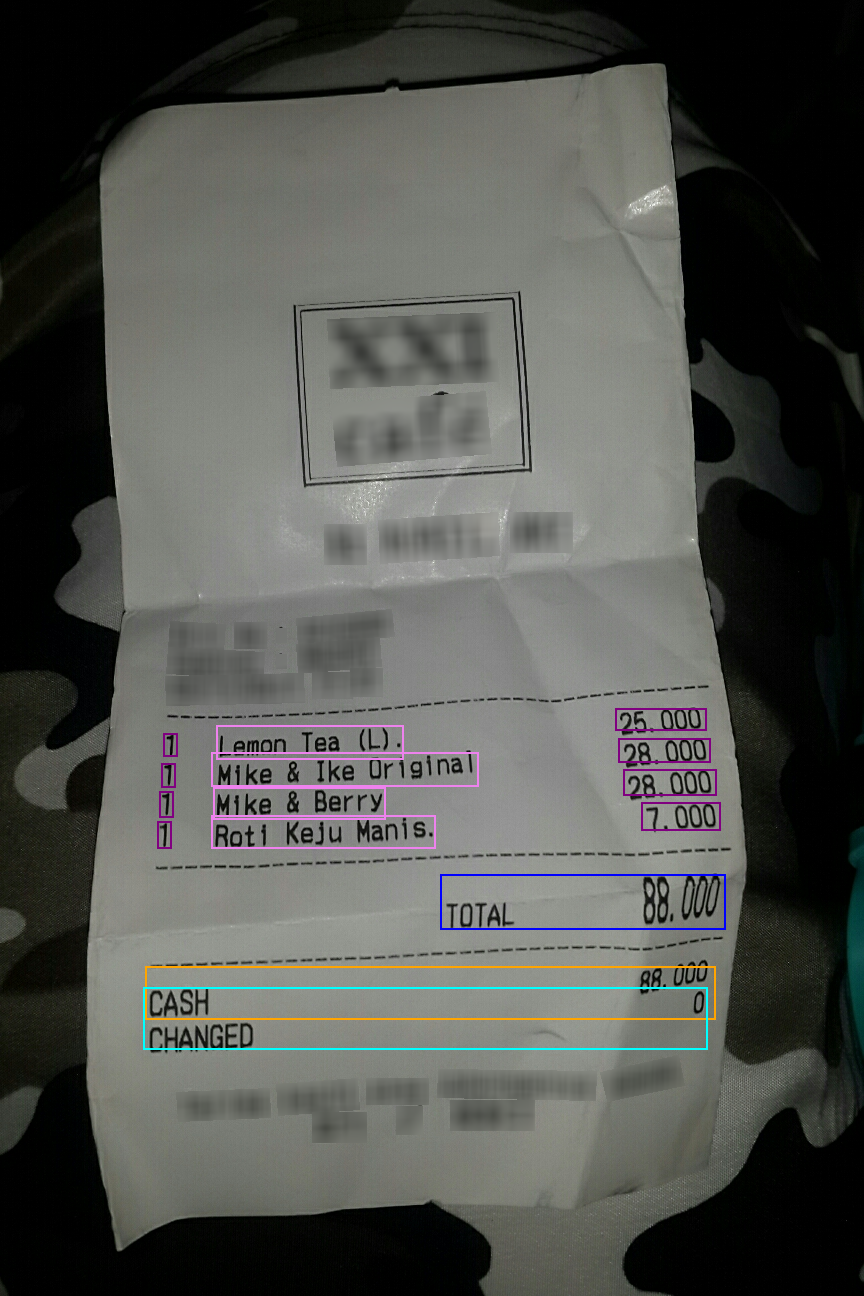

In [24]:
#GAT-Closest
k = 0
image = Image.open(f"/home/prashant/DocDatasets/CORD/raw/test/image/{id_to_image_test_json[image_id]}.png")
image = image.convert("RGB")
draw = ImageDraw.Draw(image, "RGBA")
width, height = image.size
# for z, lab in enumerate(label_to_color):
#     draw.text((10,z*10), text=f'{lab}:{label_to_color[lab]}', fill=label_to_color[lab], font=font)

for bbox, label in zip(test_dataset['bbox'][image_id], test_dataset['labels'][image_id]):
    if label!=-100:
        un_bb = unnormalize_box(bbox, width, height)
        draw.rectangle(un_bb, outline=label_to_color[test_gat_closest_preds[image_id][k]], width=2)
        # draw.text((un_bb[0]+5, un_bb[1]), text=label_list[label], fill=label_to_color[test_gat_closest_preds[image_id][k]], font=font)
        k+=1
image

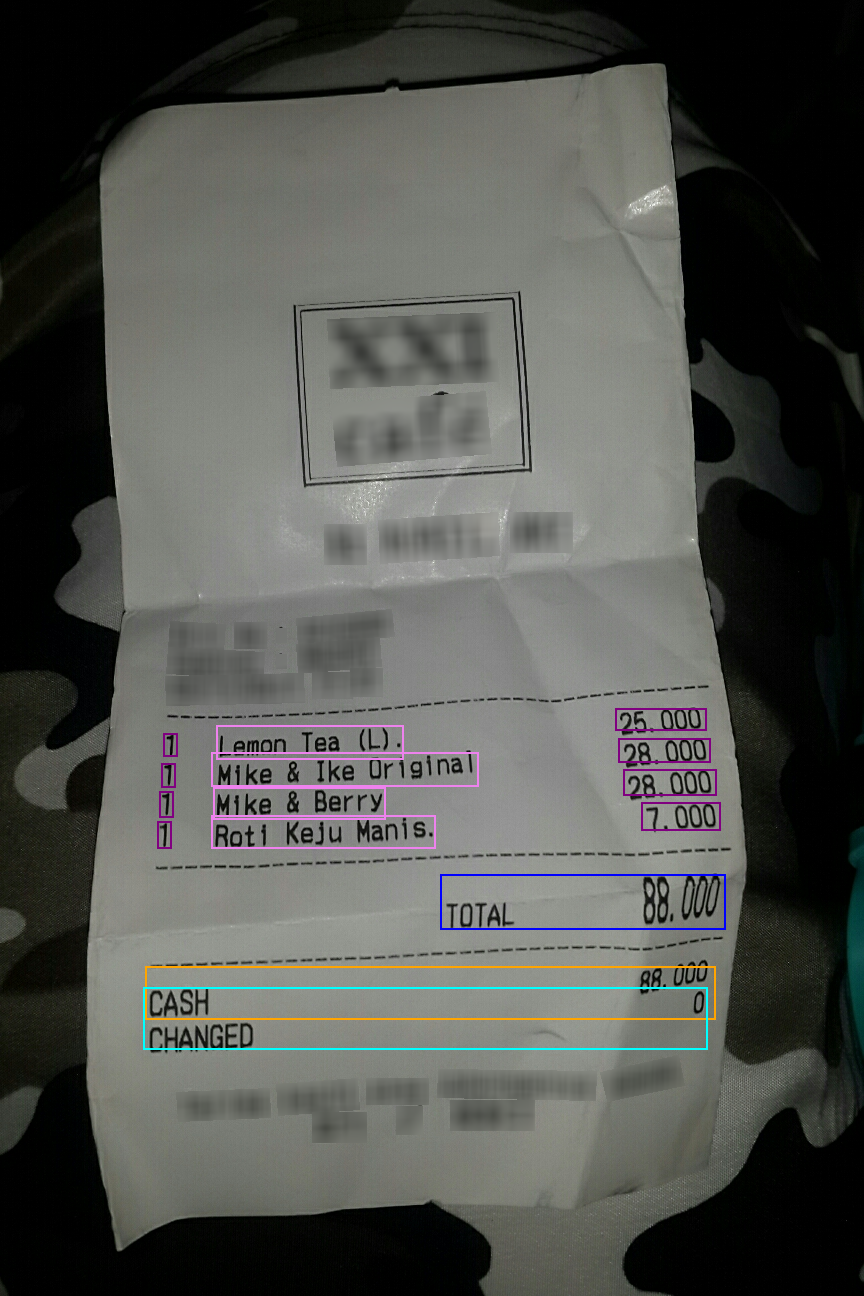

In [25]:
#GAT-60-angles-v2
k = 0
image = Image.open(f"/home/prashant/DocDatasets/CORD/raw/test/image/{id_to_image_test_json[image_id]}.png")
image = image.convert("RGB")
draw = ImageDraw.Draw(image, "RGBA")
width, height = image.size
# for z, lab in enumerate(label_to_color):
#     draw.text((10,z*10), text=f'{lab}:{label_to_color[lab]}', fill=label_to_color[lab], font=font)

for bbox, label in zip(test_dataset['bbox'][image_id], test_dataset['labels'][image_id]):
    if label!=-100:
        un_bb = unnormalize_box(bbox, width, height)
        draw.rectangle(un_bb, outline=label_to_color[test_gat_angles_preds[image_id][k]], width=2)
        # draw.text((un_bb[0]+5, un_bb[1]), text=label_list[label], fill=label_to_color[test_gat_angles_preds[image_id][k]], font=font)
        k+=1
image

In [26]:
def get_filewise_metrics_csv(test_predictions, true_labels):
    filewise_metrics_csv = pd.DataFrame()
    row = defaultdict(float)
    tag_spec = ['precision','recall','f1','number']
    i = 0
    for preds, labels in zip(test_predictions, true_labels):
        row['id'] = i
        result = metric.compute(predictions=[preds], references=[labels])
        # for k in ['ANSWER','QUESTION','HEADER']:
        #     for x in tag_spec:
        #             try:
        #                 row[f"{k}_{x}"] = result[k][x]
        #             except:
        #                 row[f"{k}_{x}"] = 0
        row['overall_precision'] = result['overall_precision']
        row['overall_recall'] = result['overall_precision']
        row['overall_f1'] = result['overall_f1']
        row['overall_accuracy'] = result['overall_accuracy']
        filewise_metrics_csv = filewise_metrics_csv.append(row, ignore_index=True)
        i+=1
    return filewise_metrics_csv

In [27]:
# true_labels = np.genfromtxt('/home/prashant/unilm/layoutlmv3/data/cord_labels.txt', dtype='str',delimiter=',,,')
# true_labels_1 = [eval(x) for x in true_labels]

In [26]:
sz, sd = 4,1
test_fs_preds = np.genfromtxt(f'/home/prashant/unilm/layoutlmv3/results/test-layoutlmv3-cord-fs-{sz}-{sd}/test_predictions.txt',dtype='str',delimiter=',,,,')
test_gat_closest_preds = np.genfromtxt(f'/home/prashant/unilm/layoutlmv3/results/test-layoutlmv3-cord-gat-closest-{sz}-{sd}-h4-d4/test_predictions.txt',dtype='str',delimiter=',,,,')
test_gat_angles_preds = np.genfromtxt(f'/home/prashant/unilm/layoutlmv3/results/test-layoutlmv3-cord-gat-60-angles-v2-{sz}-{sd}-h4-d4/test_predictions.txt',dtype='str',delimiter=',,,,')
test_fs_preds = [x.split() for x in test_fs_preds]
test_gat_closest_preds = [x.split() for x in test_gat_closest_preds]
test_gat_angles_preds = [x.split() for x in test_gat_angles_preds]

In [34]:
x_sum,y_sum = 0,0
for x,y in zip(true_labels_1, test_fs_preds):
    print(len(x), len(y))
    x_sum+=len(x)
    y_sum+=len(y)


18 24
11 12
18 25
19 12
16 23
14 16
21 19
21 16
24 28
12 11
15 13
37 12
11 23
21 25
26 40
26 15
10 36
12 37
19 11
22 18
17 33
36 24
20 18
14 14
37 25
50 20
25 35
19 17
19 22
12 47
15 16
12 23
12 15
20 28
32 21
32 23
22 18
20 11
10 51
28 56
30 20
70 41
21 20
18 30
19 10
26 27
12 20
18 36
28 19
15 22
10 14
16 39
20 20
22 27
21 9
18 14
12 13
25 8
15 19
45 59
11 28
31 53
21 16
23 26
12 9
23 13
7 19
33 14
11 9
24 22
25 66
18 12
19 14
9 21
14 40
36 37
26 18
22 16
33 16
34 16
9 15
30 22
30 30
16 17
26 24
15 64
14 20
19 18
54 22
24 19
12 18
17 13
24 13
60 20
26 30
20 23
18 18
11 19
11 27
32 59


In [33]:
test_fs_preds[0]

['B-TOTAL.CASHPRICE',
 'I-TOTAL.CASHPRICE',
 'B-TOTAL.TOTAL_PRICE',
 'I-TOTAL.TOTAL_PRICE',
 'B-TOTAL.CASHPRICE',
 'I-TOTAL.CASHPRICE',
 'B-TOTAL.CREDITCARDPRICE',
 'B-TOTAL.CASHPRICE',
 'B-TOTAL.CASHPRICE',
 'I-SUB_TOTAL.ETC',
 'I-TOTAL.CASHPRICE',
 'I-TOTAL.CASHPRICE',
 'B-MENU.NUM',
 'B-TOTAL.MENUQTY_CNT',
 'I-SUB_TOTAL.ETC',
 'B-MENU.CNT',
 'I-TOTAL.TOTAL_PRICE',
 'B-MENU.PRICE',
 'B-TOTAL.TOTAL_PRICE',
 'I-TOTAL.TOTAL_PRICE',
 'B-TOTAL.TOTAL_PRICE',
 'B-TOTAL.CASHPRICE',
 'I-SUB_TOTAL.ETC',
 'I-TOTAL.TOTAL_PRICE']

In [60]:
result = metric.compute(predictions=[test_fs_preds[0]], references=[true_labels[0]])

/home/prashant/anaconda3/envs/layoutlmv3/lib/python3.7/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/prashant/anaconda3/envs/layoutlmv3/lib/python3.7/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [62]:
result.keys()

dict_keys(['MENU.CNT', 'MENU.ITEMSUBTOTAL', 'MENU.NM', 'MENU.NUM', 'MENU.PRICE', 'SUB_TOTAL.DISCOUNT_PRICE', 'SUB_TOTAL.ETC', 'SUB_TOTAL.SUBTOTAL_PRICE', 'SUB_TOTAL.TAX_PRICE', 'TOTAL.CASHPRICE', 'TOTAL.CREDITCARDPRICE', 'TOTAL.MENUQTY_CNT', 'TOTAL.TOTAL_PRICE', 'overall_precision', 'overall_recall', 'overall_f1', 'overall_accuracy'])

In [58]:
true_labels

[]

In [15]:
# test_fs_preds = np.genfromtxt('/home/prashant/unilm/layoutlmv3/results/test-layoutlmv3-cord-fs-4-1/test_predictions.txt',dtype='str',delimiter=',,,,')
# test_gat_closest_preds = np.genfromtxt('/home/prashant/unilm/layoutlmv3/results/test-layoutlmv3-cord-gat-closest-4-1-h4-d4/test_predictions.txt',dtype='str',delimiter=',,,,')
# test_gat_angles_preds = np.genfromtxt('/home/prashant/unilm/layoutlmv3/results/test-layoutlmv3-cord-gat-60-angles-v2-4-1-h4-d4/test_predictions.txt',dtype='str',delimiter=',,,,')
# true_labels = np.genfromtxt('/home/prashant/unilm/layoutlmv3/data/cord_labels.txt', dtype='str',delimiter=',,,')

In [68]:
sizes = [1,2,3,4,5,6,7,8,9,10]
seeds = [0,1,2,3,4,5]
# true_labels = np.genfromtxt('/home/prashant/unilm/layoutlmv3/data/cord_labels.txt', dtype='str',delimiter=',,,')
# true_labels_1 = [eval(x) for x in true_labels]
true_labels_1 = pickle.load(open('/home/prashant/unilm/layoutlmv3/data/cord_true_labels.pkl','rb'))
gat_closest_counts, gat_angles_counts = [],[]
for sz in sizes:
    print("Sz ", sz)
    closest_counts, angles_counts = [],[]
    for sd in seeds:
        test_fs_preds = np.genfromtxt(f'/home/prashant/unilm/layoutlmv3/results/test-layoutlmv3-cord-fs-{sz}-{sd}/test_predictions.txt',dtype='str',delimiter=',,,,')
        test_gat_closest_preds = np.genfromtxt(f'/home/prashant/unilm/layoutlmv3/results/test-layoutlmv3-cord-gat-closest-{sz}-{sd}-h4-d4/test_predictions.txt',dtype='str',delimiter=',,,,')
        test_gat_angles_preds = np.genfromtxt(f'/home/prashant/unilm/layoutlmv3/results/test-layoutlmv3-cord-gat-60-angles-v2-{sz}-{sd}-h4-d4/test_predictions.txt',dtype='str',delimiter=',,,,')
        test_fs_preds = [x.split() for x in test_fs_preds]
        test_gat_closest_preds = [x.split() for x in test_gat_closest_preds]
        test_gat_angles_preds = [x.split() for x in test_gat_angles_preds]
        filewise_baseline = get_filewise_metrics_csv(test_fs_preds, true_labels_1)
        filewise_gat_closest = get_filewise_metrics_csv(test_gat_closest_preds, true_labels_1)
        filewise_gat_angles = get_filewise_metrics_csv(test_gat_angles_preds, true_labels_1)
        closest_counts.append(sum(filewise_baseline['overall_f1'] <= filewise_gat_closest['overall_f1']))
        angles_counts.append(sum(filewise_baseline['overall_f1'] <= filewise_gat_angles['overall_f1']))
    print(closest_counts)
    print(angles_counts)
    gat_closest_counts.append(np.mean(closest_counts))
    gat_angles_counts.append(np.mean(angles_counts))


Sz  1
[48, 53, 45, 82, 70, 57]
[48, 47, 47, 81, 59, 51]
Sz  2
[61, 63, 67, 67, 85, 62]
[54, 64, 65, 58, 85, 56]
Sz  3
[79, 69, 61, 66, 69, 79]
[71, 65, 59, 70, 76, 75]
Sz  4
[64, 73, 67, 80, 74, 67]
[69, 71, 59, 75, 75, 62]
Sz  5
[73, 64, 67, 74, 72, 72]
[68, 62, 59, 73, 76, 65]
Sz  6
[69, 61, 68, 62, 88, 62]
[75, 64, 64, 55, 86, 64]
Sz  7
[69, 74, 47, 61, 81, 68]
[73, 72, 55, 73, 76, 64]
Sz  8
[75, 66, 52, 64, 80, 55]
[64, 70, 58, 67, 82, 56]
Sz  9
[76, 78, 60, 65, 70, 69]
[76, 62, 62, 63, 78, 70]
Sz  10
[82, 63, 70, 69, 74, 77]
[82, 64, 53, 62, 73, 68]


In [72]:
print("CORD - closest")
avgs = []
for i, avg in enumerate(gat_closest_counts):
    print(f'Sz : {i+1} {avg} {avg/100}')
    avgs.append(avg/100)
print("AVG: ",np.mean(avgs))

avgs = []
print("CORD - angles")
for i, avg in enumerate(gat_angles_counts):
    print(f'Sz : {i+1} {avg} {avg/100}')
    avgs.append(avg/100)
print("AVG: ",np.mean(avgs))
    

CORD - closest
Sz : 1 59.166666666666664 0.5916666666666667
Sz : 2 67.5 0.675
Sz : 3 70.5 0.705
Sz : 4 70.83333333333333 0.7083333333333333
Sz : 5 70.33333333333333 0.7033333333333333
Sz : 6 68.33333333333333 0.6833333333333332
Sz : 7 66.66666666666667 0.6666666666666667
Sz : 8 65.33333333333333 0.6533333333333333
Sz : 9 69.66666666666667 0.6966666666666668
Sz : 10 72.5 0.725
AVG:  0.6808333333333334
CORD - angles
Sz : 1 55.5 0.555
Sz : 2 63.666666666666664 0.6366666666666666
Sz : 3 69.33333333333333 0.6933333333333332
Sz : 4 68.5 0.685
Sz : 5 67.16666666666667 0.6716666666666667
Sz : 6 68.0 0.68
Sz : 7 68.83333333333333 0.6883333333333332
Sz : 8 66.16666666666667 0.6616666666666667
Sz : 9 68.5 0.685
Sz : 10 67.0 0.67
AVG:  0.6626666666666667


In [64]:
true_labels = []
for ls in test_dataset['labels']:
    true_labs = []
    for l in ls:
        if l!=-100:
            true_labs.append(label_list[l])
    true_labels.append(true_labs)

In [66]:
# pickle.dump(true_labels, open('/home/prashant/unilm/layoutlmv3/data/cord_true_labels.pkl','wb'))